In [1]:
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    MultilayerPerceptron,
    Parser,
    PerceptronActivationType,
    Simulator,
    PlanarSceneGraphVisualizer,
    ZeroOrderHold,
    FittedValueIteration,
    DynamicProgrammingOptions,
    SceneGraph,
    PeriodicBoundaryCondition,
)
from value_iteration import *
from functools import partial
import pandas as pd
from pydrake.examples.pendulum import PendulumGeometry, PendulumPlant

# Cartpole Simple Function Estimation

In [12]:
def fitted_value_iteration(
    num_samples={"x": 20, "theta": 50, "x_dot": 20, "theta_dot": 20},
    ranges={
        "x": (-2, 2),
        "theta": (np.pi - 0.5, np.pi + 0.5),
        "x_dot": (-5, 5),
        "theta_dot": (-5, 5),
    },
    input_limit=3,
    num_inputs=20,
    target_state={"x": 0, "theta": np.pi, "x_dot": 0, "theta_dot": 0},
):
    input_port = 3
    Q = np.diag([0.1, 20, 1, 1])
    R = np.diag([2])

    plant, _, _ = create_cartpole()
    simulator = Simulator(plant)

    state_grid = [set(v) for v in create_state_space(num_samples, ranges, target_state).values()]
    input_grid = [set(np.append(np.linspace(-input_limit, input_limit, num_inputs), 0))]
    timestep = 0.01

    def quadratic_cost(Q, R, target_state):
        def cost(context):
            state = context.get_continuous_state_vector().CopyToVector()
            x = state - target_state
            u = plant.EvalVectorInput(context, input_port).CopyToVector()
            return np.einsum("x,xx,x", x, Q, x) + np.einsum("u,uu,u", u, R, u)

        return cost

    options = DynamicProgrammingOptions()
    options.periodic_boundary_conditions = [
        PeriodicBoundaryCondition(1, 0, 2 * np.pi),
    ]
    options.discount_factor = 0.9999
    options.convergence_tol = 0.1
    options.input_port_index = plant.get_input_port(input_port).get_index()

    policy, cost_to_go = FittedValueIteration(
        simulator,
        quadratic_cost(Q, R, [v for v in target_state.values()]),
        state_grid,
        input_grid,
        timestep,
        options,
    )
    pandas_grid = create_pandas_grid(num_samples, ranges, target_state)
    pandas_grid["J"] = cost_to_go
    pandas_grid["policy"] = policy

    return policy, cost_to_go, pandas_grid


policy, cost_to_go, states = fitted_value_iteration()


INFO:drake:Computing transition and cost matrices.
INFO:drake:Done computing transition and cost matrices.
INFO:drake:Running value iteration.
INFO:drake:Value iteration converged to requested tolerance.


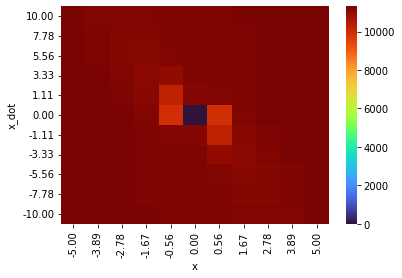

In [14]:
plot_cost_to_go(
    states[(states["theta"] == np.pi) & (states["theta_dot"] == 0)],
    {"name": "x", "is_angle": False},
    {"name": "x_dot", "is_angle": False},
)

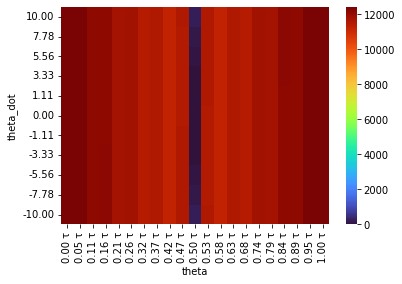

In [13]:
plot_cost_to_go(
    states[(states["x"] == 0) & (states["x_dot"] == 0)],
    {"name": "theta", "is_angle": True},
    {"name": "theta_dot", "is_angle": False},
)


In [21]:
# plot_cost_to_go(
#     states[(states["theta"] == np.pi) & (states["theta_dot"] == 0)],
#     {"name": "x", "is_angle": False},
#     {"name": "x_dot", "is_angle": False},
# )
# plot_cost_to_go(
#     states[(states["x"] == 0) & (states["x_dot"] == 0)],
#     {"name": "theta", "is_angle": True},
#     {"name": "theta_dot", "is_angle": False},
# )
cost_to_go

cost_to_go = np.reshape(cost_to_go, Q.shape)

plot_surface(meshcat, 'Cost-to-go', Q, Qdot, J, wireframe=True)

if animate:
    print('Simulating...')
    simulate(policy)

if plot:
    fig = plt.figure(1, figsize=(9, 4))
    ax1, ax2 = fig.subplots(1, 2)
    ax1.set_xlabel("q")
    ax1.set_ylabel("qdot")
    ax1.set_title("Cost-to-Go")
    ax2.set_xlabel("q")
    ax2.set_ylabel("qdot")
    ax2.set_title("Policy")
    ax1.imshow(J,
                cmap=cm.jet,
                extent=(qbins[0], qbins[-1], qdotbins[-1], qdotbins[0]))
    ax1.invert_yaxis()
    Pi = np.reshape(policy.get_output_values(), Q.shape)
    ax2.imshow(Pi,
                cmap=cm.jet,
                extent=(qbins[0], qbins[-1], qdotbins[-1], qdotbins[0]))
    ax2.invert_yaxis()
    display(plt.show())


NameError: name 'cost_to_go' is not defined

# Cartpole Neural Net Training

In [23]:
Q = np.diag([0.1, 20, 1, 1])
R = np.array([2])


def train_cart_pole(
    num_samples={"x": 20, "theta": 50, "x_dot": 20, "theta_dot": 20},
    ranges={
        "x": (-5, 5),
        "theta": (0, 2 * np.pi),
        "x_dot": (-10, 10),
        "theta_dot": (-10, 10),
    },
    lr=1e-4,
    epochs=300,
    steps_per_epoch=100,
    target_state={"x": 0.0, "theta": np.pi, "x_dot": 0.0, "theta_dot": 0.0},
    discount_factor=0.9999,
):
    assert target_state != None

    # Create the plant
    plant, context, _ = create_cartpole()

    # Create a state space grid, ensuring that the target state is included
    states = {
        k: np.unique(
            np.append(
                np.linspace(ranges[k][0], ranges[k][1], num_samples[k]), target_state[k]
            )
        )
        for k in num_samples
    }
    state_grid_cart = np.meshgrid(
        states["x"],
        states["theta"],
        states["x_dot"],
        states["theta_dot"],
        indexing="ij",
    )
    num_samples = {k: states[k].size for k in states}
    state_grid = np.vstack([s.flatten() for s in state_grid_cart])

    # zero cost state
    target_state = np.array([v for v in target_state.values()]).reshape(-1, 1)

    # A neural network for the cartpole
    mlp = MultilayerPerceptron(
        [False, True, False, False],
        [100, 100, 1],
        [
            PerceptronActivationType.kReLU,
            PerceptronActivationType.kReLU,
            PerceptronActivationType.kIdentity,
        ],
    )

    # train the neural network
    mlp_context, loss_over_time = ContinuousFittedValueIteration(
        plant,
        context,
        mlp,
        partial(compute_state_cost, Q, target_state),
        compute_u_star,
        R,
        state_grid,
        time_step=0.01,
        discount_factor=discount_factor,
        lr=lr,
        minibatch=32,
        epochs=epochs,
        optimization_steps_per_epoch=steps_per_epoch,
        input_limits=None,
        target_state=target_state,
    )

    J = mlp.BatchOutput(mlp_context, state_grid)[0]

    states = pd.DataFrame(
        {
            "x": state_grid[0],
            "theta": state_grid[1],
            "x_dot": state_grid[2],
            "theta_dot": state_grid[3],
            "J": J,
        }
    )

    return mlp, mlp_context, loss_over_time, states


mlp, mlp_context, loss_over_time, states = train_cart_pole(
    epochs=200,
    discount_factor=0.9999,
    lr=1e-4,
    steps_per_epoch=100,
    ranges={
        "x": (-2, 2),
        "theta": (np.pi - 0.5, np.pi + 0.5),
        "x_dot": (-5, 5),
        "theta_dot": (-5, 5),
    },
)

plot_loss(loss_over_time)

'loss: 0.00324996 epoch: 199/200'

alt.Chart(...)

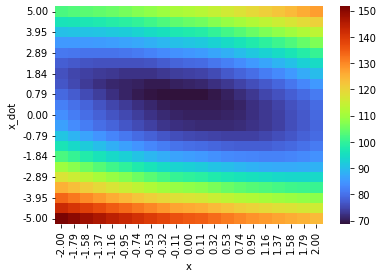

In [24]:
plot_cost_to_go(
    states[(states["theta"] == np.pi) & (states["theta_dot"] == 0)],
    {"name": "x", "is_angle": False},
    {"name": "x_dot", "is_angle": False},
)

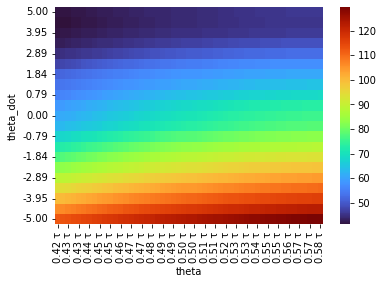

In [26]:
plot_cost_to_go(
    states[(states["x"] == 0) & (states["x_dot"] == 0)],
    {"name": "theta", "is_angle": True},
    {"name": "theta_dot", "is_angle": False},
)


# Input controller

In [6]:
# initialize controller and plant
diagram_builder = DiagramBuilder()

cart_plant_cl, cart_scene_graph_cl = AddMultibodyPlantSceneGraph(
    diagram_builder, time_step=0.0
)

Parser(cart_plant_cl).AddModelFromFile("cartpole.urdf")
cart_plant_cl.Finalize()
cart_plant_context_cl = cart_plant_cl.CreateDefaultContext()
cart_controller_sys = ContinuousFittedValueIterationPolicy(
    cart_plant_cl,
    mlp,
    mlp_context,
    R,
    compute_u_star,
)

cart_controller = diagram_builder.AddSystem(cart_controller_sys)
# we assume a zero-order hold between time steps
time_step = 0.01
zoh_cart = diagram_builder.AddSystem(ZeroOrderHold(time_step, 1))

# wire all the systems together
diagram_builder.Connect(
    cart_plant_cl.get_state_output_port(), cart_controller.get_input_port()
)
diagram_builder.Connect(cart_controller.get_output_port(), zoh_cart.get_input_port())
diagram_builder.Connect(
    zoh_cart.get_output_port(), cart_plant_cl.get_actuation_input_port()
)

# Add visualizer
visualizer = diagram_builder.AddSystem(
    PlanarSceneGraphVisualizer(
        cart_scene_graph_cl, xlim=[-3.0, 3.0], ylim=[-.5, 1.2], show=False
    )
)
diagram_builder.Connect(
    cart_scene_graph_cl.get_query_output_port(), visualizer.get_input_port(0)
)

# Simulate
simulator = Simulator(diagram_builder.Build())
simulator.set_publish_every_time_step(False)  # makes sim faster

simulate_and_animate([0, np.pi, 0, 0], visualizer, simulator, sim_time=10)


# Test with fixed input controller

In [ ]:
def simulate_fixed_input_controller():
    # initialize plant
    diagram_builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(diagram_builder, time_step=0.0)
    Parser(plant).AddModelFromFile("cartpole.urdf")
    plant.Finalize()

    # Add visualizer
    visualizer = diagram_builder.AddSystem(
        PlanarSceneGraphVisualizer(
            scene_graph, xlim=[-3.0, 3.0], ylim=[-0.5, 1.2], show=False
        )
    )
    diagram_builder.Connect(
        scene_graph.get_query_output_port(), visualizer.get_input_port(0)
    )

    # set up simulator
    diagram = diagram_builder.Build()
    simulator = Simulator(diagram)
    simulator_context = simulator.get_mutable_context()

    # setup input
    fixed_input = np.array([10])
    plant_context = diagram.GetMutableSubsystemContext(plant, simulator_context)
    plant.get_actuation_input_port().FixValue(plant_context, fixed_input)

    simulate_and_animate([-2, np.pi, 0, 0], visualizer, simulator, sim_time=4)

simulate_fixed_input_controller()

# Pendulum training

In [ ]:
def train(num_samples=41, epochs=10, target_state=[np.pi, 0.0], discount_factor=0.9999):
    Q = np.diag([10, 1])
    R = np.array([1])

    # Create the plant
    plant = PendulumPlant()
    plant_context = plant.CreateDefaultContext()

    # Create the state grid
    theta_states = np.linspace(0, 2 * np.pi, num_samples)
    theta_dot_states = np.linspace(-10, 10, num_samples)
    state_grid_cart = np.meshgrid(
        theta_states,
        theta_dot_states,
    )
    state_grid = np.vstack([s.flatten() for s in state_grid_cart])

    # zero cost state
    target_state = np.array(target_state).reshape(-1, 1)

    # A neural network for the cartpole
    mlp = MultilayerPerceptron(
        # whether to send input i to cos(x_i), sin(x_i)
        [True, False],
        [164, 164, 1],
        [
            PerceptronActivationType.kReLU,
            PerceptronActivationType.kReLU,
            PerceptronActivationType.kIdentity,
        ],
    )
    torque_limit = 3

    # train the neural network
    mlp_context, loss_over_time = ContinuousFittedValueIteration(
        plant,
        plant_context,
        mlp,
        partial(compute_state_cost, Q, target_state),
        compute_u_star,
        R,
        state_grid,
        time_step=0.01,
        discount_factor=discount_factor,
        lr=1e-4,
        minibatch=32,
        epochs=epochs,
        optimization_steps_per_epoch=100,
        input_limits=[-torque_limit, torque_limit],
        target_state=target_state,
    )

    J = mlp.BatchOutput(mlp_context, state_grid)[0].reshape(num_samples, num_samples)

    return mlp, mlp_context, loss_over_time, state_grid_cart, J


mlp, mlp_context, loss_over_time, state_grid, J = train(
    epochs=300, num_samples=41, discount_factor=0.999
)


# Visualize pendulum NN

In [7]:
plot_cost_to_go(state_grid, J)

NameError: name 'state_grid' is not defined

In [ ]:
plot_loss(loss_over_time)

# Pendulum input controller

In [ ]:
def control_pendulum():
    R = np.array([1])
    builder = DiagramBuilder()
    scene_graph = builder.AddSystem(SceneGraph())
    plant = builder.AddSystem(PendulumPlant())
    PendulumGeometry.AddToBuilder(builder, plant.get_state_output_port(), scene_graph)

    controller = ContinuousFittedValueIterationPolicy(
        plant,
        mlp,
        mlp_context,
        R,
        compute_u_star,
        input_limits=[-3, 3],
    )

    cart_controller = builder.AddSystem(controller)
    # we assume a zero-order hold between time steps
    time_step = 0.01
    zoh_cart = builder.AddSystem(ZeroOrderHold(time_step, 1))

    # wire all the systems together
    builder.Connect(
        plant.get_state_output_port(), cart_controller.get_input_port()
    )
    builder.Connect(cart_controller.get_output_port(), zoh_cart.get_input_port())
    builder.Connect(
        zoh_cart.get_output_port(), plant.get_input_port(0)
    )

    # Add visualizer
    visualizer = builder.AddSystem(
        PlanarSceneGraphVisualizer(
            scene_graph, xlim=[-1.2, 1.2], ylim=[-1.2, 1.2], show=False
        )
    )
    builder.Connect(
        scene_graph.get_query_output_port(), visualizer.get_input_port(0)
    )

    # Simulate
    simulator = Simulator(builder.Build())
    simulator.set_publish_every_time_step(False)  # makes sim faster

    return simulate_and_animate([0, 0], visualizer, simulator, sim_time=8)

control_pendulum()
